In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
import webdataset as wds

In [4]:
dataset = wds.WebDataset("out.tgz")

In [10]:
sample = next(iter(dataset))
the_probs = sample["probs.png"]
probs = the_probs.copy()
amax(probs)

0.99607843

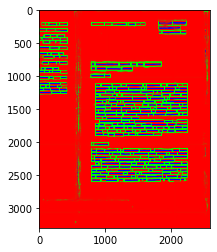

In [11]:
imshow(probs)

In [12]:
import scipy.ndimage as ndi
from ocrlib import psegutils
from itertools import islice
def pad_slice(sl, r):
    if isinstance(r, int):
        return slice(max(sl.start-r, 0), sl.stop+r)
    elif isinstance(r, float):
        d = int((0.5+sl.stop-sl.start)*r)
        return slice(max(sl.start-d, 0), sl.stop+d)
    else:
        raise ValueError(f"range {r}")

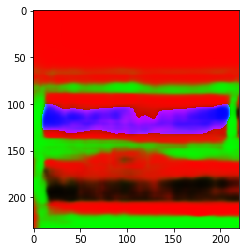

In [30]:
probs = the_probs.copy()
markers = psegutils.hysteresis_threshold(probs[:,:,2], 0.2, 0.7)
separators = probs[:,:,1]
separators = ndi.maximum_filter(separators, 3)
word_labels, n = ndi.label(markers)
for i, bounds in enumerate(ndi.find_objects(word_labels)):
    vslice, xslice = bounds
    xvslice = pad_slice(vslice, 100)
    xslice = pad_slice(xslice, 10)
    simage = probs[xvslice, xslice].copy()
    mask = 1.0*(word_labels[xvslice, xslice]==i+1)
    #simage[:,:,1] = np.clip(simage[:,:,0] - mask, 0, 1)
    simage[:,:,2] = mask # * probs[xvslice, xslice,2]
    break
imshow(simage)


1


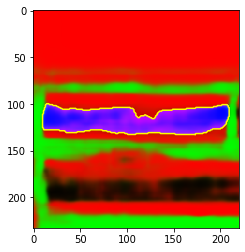

In [31]:
from skimage import measure
contours = measure.find_contours(mask, 0.5)
print(len(contours))
contour = contours[0]
imshow(simage)
plot(contour[:, 1], contour[:, 0], color="yellow")

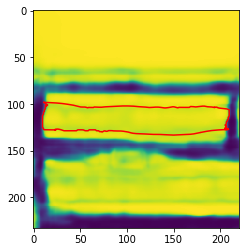

In [37]:
from skimage.segmentation import active_contour
snake = active_contour(1-simage[:,:,1], contour, alpha=0.015, beta=10, gamma=0.001, w_edge=1,coordinates="rc")
imshow(1-simage[:,:,1])
plot(snake[:, 1], snake[:, 0], color="red")

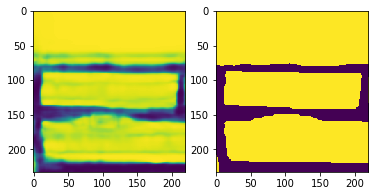

In [41]:
from skimage.segmentation import chan_vese
seg = chan_vese(1-simage[:,:,1], init_level_set="checkerboard")
subplot(121); imshow(1-simage[:,:,1])
subplot(122); imshow(seg)